In [1]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow.keras.layers as layers
import time
import tensorflow as tf

### Load and prepare the MNIST dataset to train the generator and the discriminator.



In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0],-1).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_images.shape[0]
train_images.shape

11490434/11490434 [==============================] - 0s 0us/step


(60000, 784)

In [3]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

In [25]:
def make_generator_model():  
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(256, input_shape=(100,)))
    model.add(layers.LeakyReLU())
 
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(784, activation='tanh'))
  
    return model

In [26]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

print(generated_image.shape)
generator.summary()

(1, 784)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 1024)              525312    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_11 (Dense)            (None, 784)     

### The Discriminator


In [27]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(1024, input_shape=(784,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
 
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1))
     
    return model

In [28]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

discriminator.summary()

tf.Tensor([[-0.01446669]], shape=(1, 1), dtype=float32)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1024)              803840    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 512)               524800    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 512)               0         
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                

In [29]:
# optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Define the training loop



In [30]:
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 25

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [31]:
@tf.function
def train_step(images):
    # create noise vector
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generator
        generated_images = generator(noise, 
                                     training=True)

        # discriminator
        real_output = discriminator(images, 
                                    training=True)
        fake_output = discriminator(generated_images, 
                                    training=True)

        # compute losses
        gen_loss  = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # compute gradients
    gradients_of_generator     = gen_tape.gradient(gen_loss, 
                                                   generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                    discriminator.trainable_variables)

    # update gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, 
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, 
                                                discriminator.trainable_variables))

In [32]:
def generate_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(5,5))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        imagen = predictions[i].numpy().reshape((28,28))
        plt.imshow(imagen * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    label = 'Epoch {0}'.format(epoch)
    fig.text(0.51, 0.05, label, ha='center',fontsize=14)
    plt.show()

In [33]:
def train(dataset, epochs):  
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        if epoch%10 == 0:    
            generate_images(generator, epoch + 1, seed)

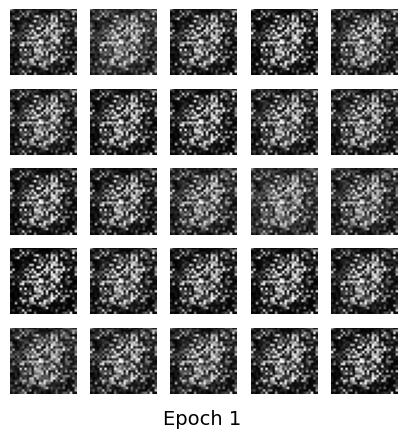

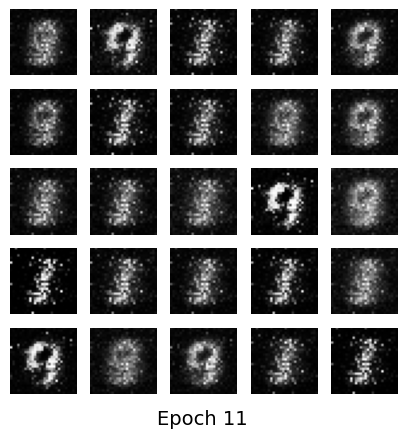

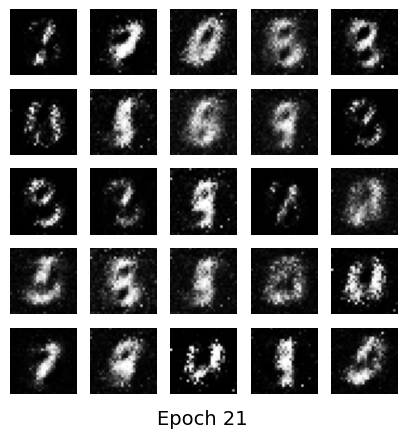

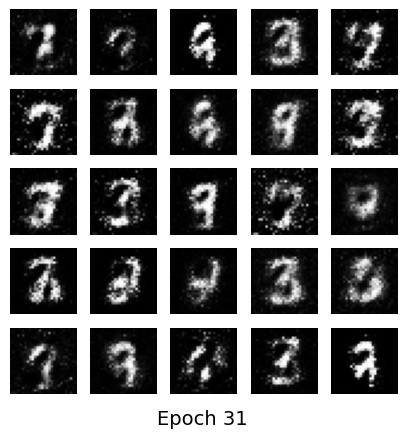

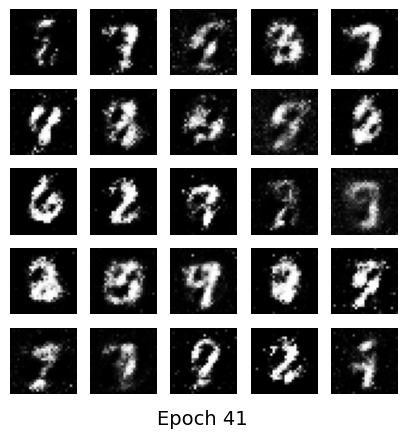

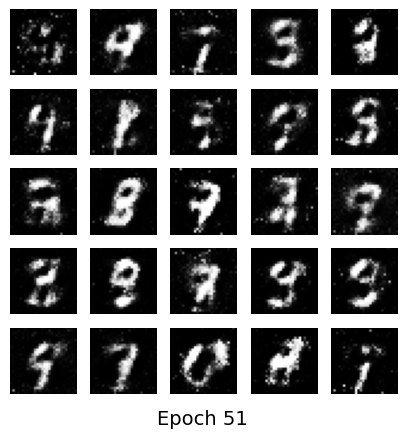

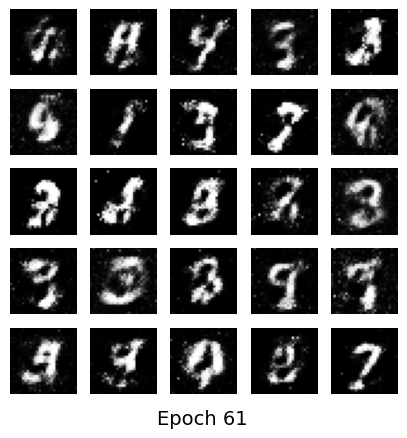

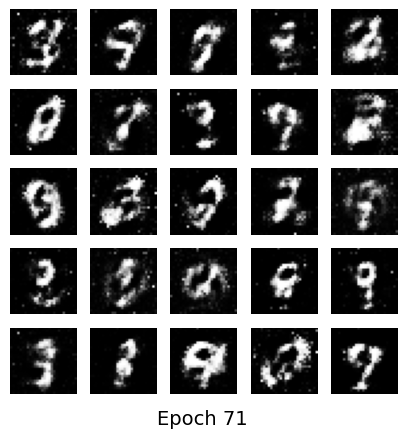

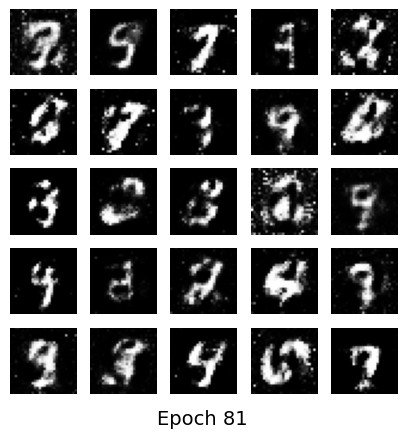

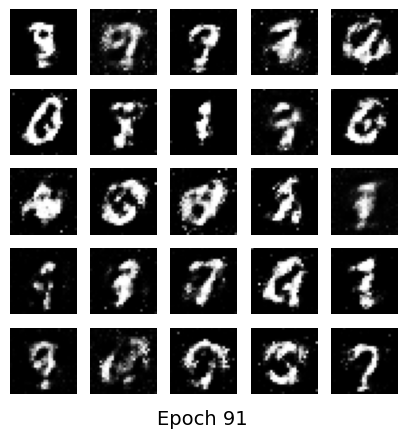

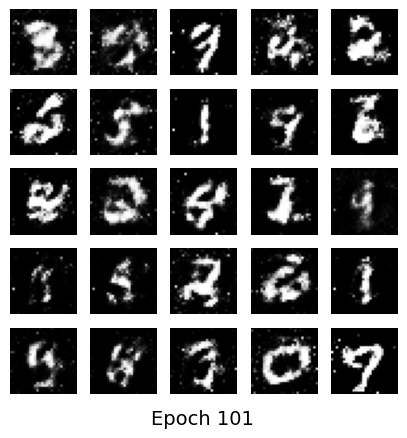

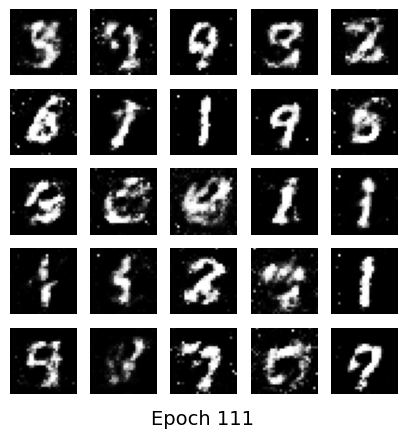

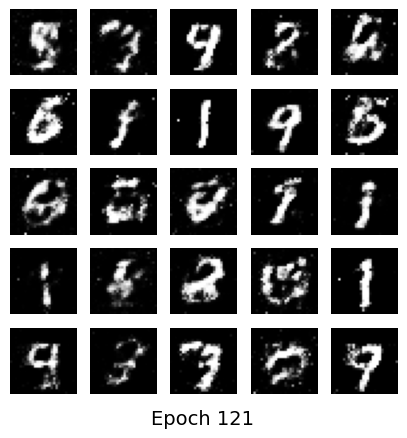

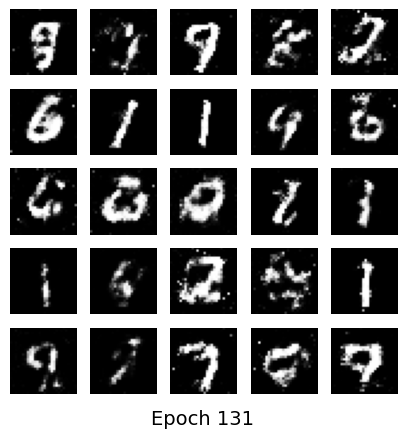

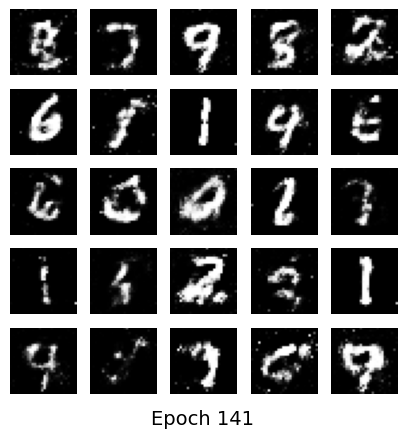

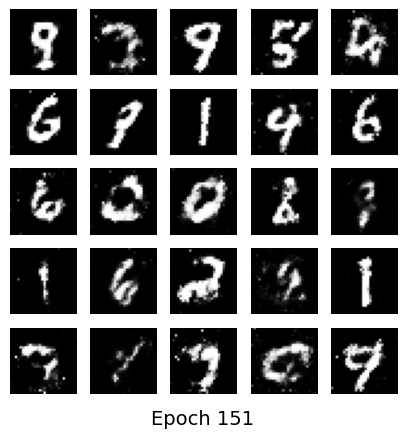

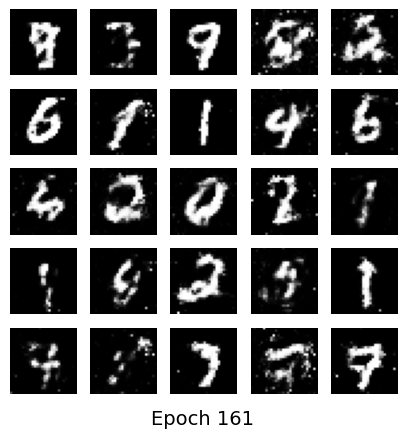

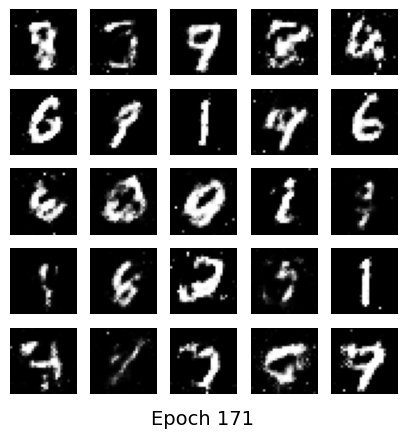

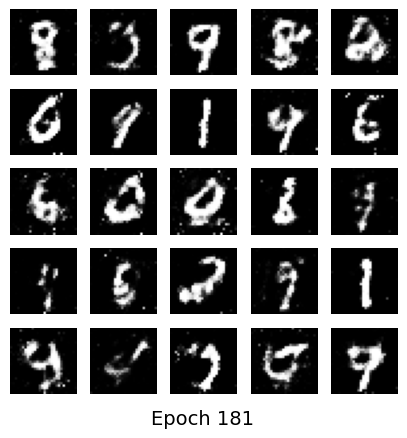

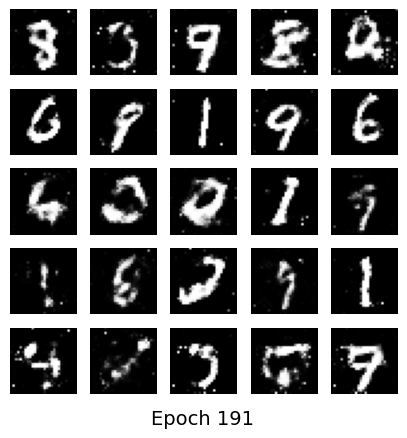

In [34]:
train(train_dataset, EPOCHS)